In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, HourLocator
from matplotlib.gridspec import GridSpec
from glob import glob
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
from ipywidgets import interact, fixed

%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

In [28]:

# ========================================
# 1. 解析延迟数据文件
# ========================================

# 示例路径 - 替换为实际文件路径
latency_df = pd.read_csv('../datas/CameraCheck/_2025_06_28.csv')
latency_df['timestamp'] = pd.to_datetime(latency_df['时间'], format='%Y/%m/%d %H:%M:%S:%f')
latency_df['latency'] = latency_df['采集时间'].str[:-2].astype(float)

In [29]:
latency_df

,时间,采集时间,timestamp,latency
0,2025/06/28 08:23:59:509,77ms,2025-06-28 08:23:59.509,77.0
1,2025/06/28 08:24:00:313,28ms,2025-06-28 08:24:00.313,28.0
2,2025/06/28 08:24:00:955,32ms,2025-06-28 08:24:00.955,32.0
3,2025/06/28 08:24:01:297,32ms,2025-06-28 08:24:01.297,32.0
4,2025/06/28 08:24:06:386,62ms,2025-06-28 08:24:06.386,62.0
...,...,...,...,...
4173,2025/06/28 16:30:15:475,40ms,2025-06-28 16:30:15.475,40.0
4174,2025/06/28 16:30:15:908,120ms,2025-06-28 16:30:15.908,120.0
4175,2025/06/28 16:30:16:022,40ms,2025-06-28 16:30:16.022,40.0
4176,2025/06/28 16:30:26:245,20ms,2025-06-28 16:30:26.245,20.0


In [30]:
# ========================================
# 2. 加载报警记录（示例结构）
# ========================================
# 假设报警记录格式：包含报警时间的DataFrame
# 实际数据需要替换这里的示例
alarms_df = pd.read_csv("../datas/报警记录/2025-06-28.csv", encoding='gbk')
alarms_df['alarm_time'] = pd.to_datetime(alarms_df['开始时间'])

print(f"Loaded {len(alarms_df)} alarm records")

Loaded 46 alarm records



===== 延迟统计对比 =====
报警时段记录数: 670
正常时段记录数: 3508

报警时段延迟统计:
count    670.000000
mean      55.379104
std       28.240101
min       19.000000
25%       32.000000
50%       56.000000
75%       67.000000
max      121.000000
Name: latency, dtype: float64

正常时段延迟统计:
count    3508.000000
mean       56.510547
std        29.320985
min        19.000000
25%        32.000000
50%        56.000000
75%        68.000000
max       126.000000
Name: latency, dtype: float64

T检验结果: t=-0.944, p=0.3452
--> 差异不显著


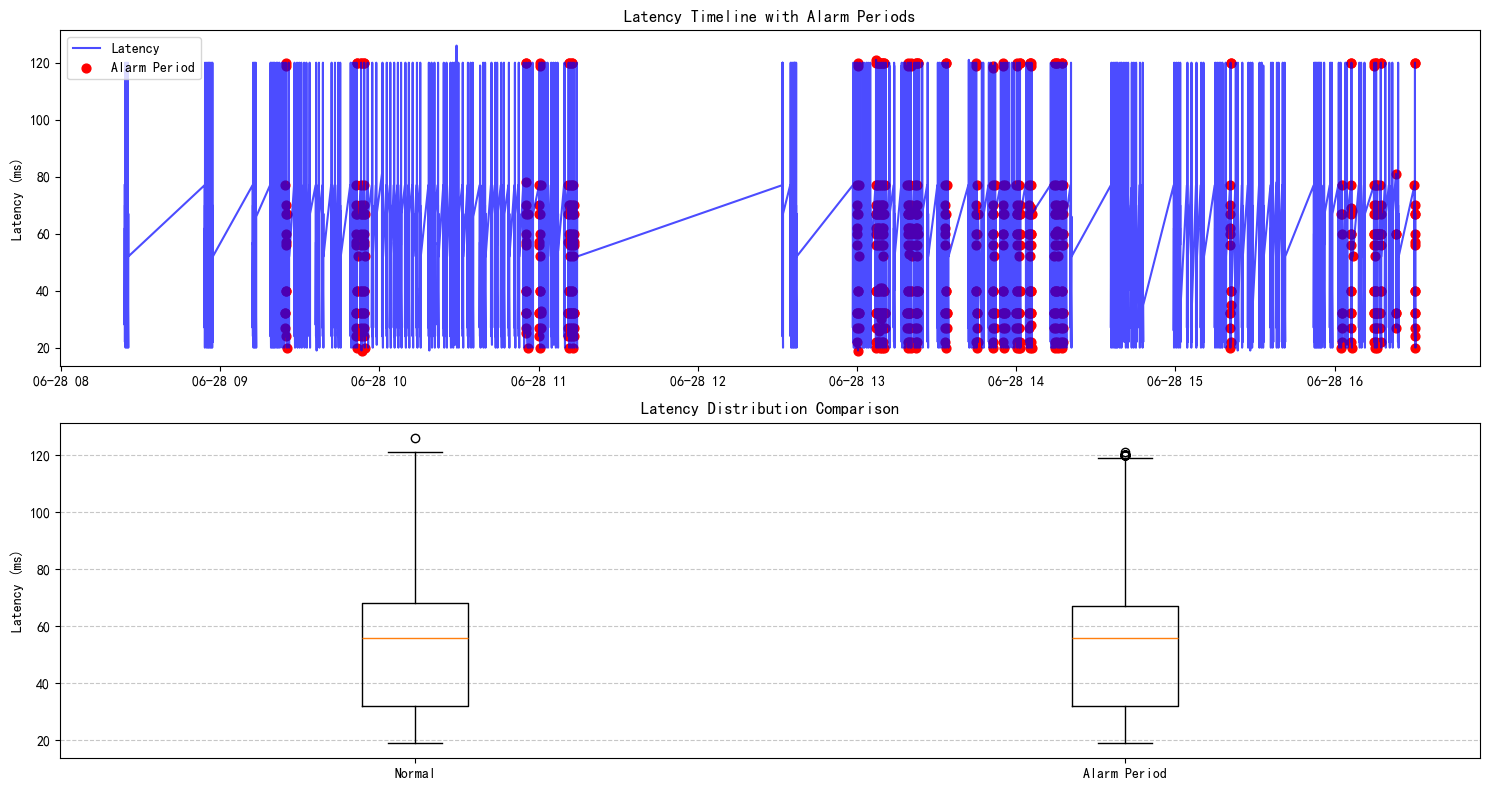

In [32]:
# ========================================
# 3. 标记报警前后时段
# ========================================
# 定义报警影响窗口（报警前后各30秒）
window_size = pd.Timedelta(seconds=30)

# 创建报警时段的标记
latency_df['is_alarm_period'] = False

for alarm_ts in alarms_df['alarm_time']:
    start_time = alarm_ts - window_size
    end_time = alarm_ts + window_size
    mask = (latency_df['timestamp'] >= start_time) & (latency_df['timestamp'] <= end_time)
    latency_df.loc[mask, 'is_alarm_period'] = True

# ========================================
# 4. 比较报警时段的延迟与非报警时段
# ========================================
alarm_latency = latency_df[latency_df['is_alarm_period']]['latency']
normal_latency = latency_df[~latency_df['is_alarm_period']]['latency']

print("\n===== 延迟统计对比 =====")
print(f"报警时段记录数: {len(alarm_latency)}")
print(f"正常时段记录数: {len(normal_latency)}")
print("\n报警时段延迟统计:")
print(alarm_latency.describe())
print("\n正常时段延迟统计:")
print(normal_latency.describe())

# T-test检验差异显著性
t_stat, p_value = stats.ttest_ind(alarm_latency, normal_latency, equal_var=False)
print(f"\nT检验结果: t={t_stat:.3f}, p={p_value:.4f}")
if p_value < 0.05:
    print("--> 报警时段与正常时段的延迟有显著差异")
else:
    print("--> 差异不显著")

# ========================================
# 5. 可视化分析
# ========================================
plt.figure(figsize=(15, 8))

# 时间序列图
plt.subplot(2, 1, 1)
plt.plot(latency_df['timestamp'], latency_df['latency'], 
         'b-', label='Latency', alpha=0.7)

# 标记报警时段
alarm_periods = latency_df[latency_df['is_alarm_period']]
plt.scatter(alarm_periods['timestamp'], alarm_periods['latency'], 
            color='red', s=40, label='Alarm Period')

plt.title('Latency Timeline with Alarm Periods')
plt.ylabel('Latency (ms)')
plt.legend()

# 箱型图对比
plt.subplot(2, 1, 2)
data = [normal_latency, alarm_latency]
plt.boxplot(data, labels=['Normal', 'Alarm Period'])
plt.title('Latency Distribution Comparison')
plt.ylabel('Latency (ms)')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('latency_analysis.png', dpi=300)
plt.show()